Libraries

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.feature_selection import chi2
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings

Datasets

In [186]:
df_original = pd.read_csv('data/df_preprocessed.csv', delimiter=',')

In [187]:
df = df_original.copy(deep = True)
df.drop(columns=['Unnamed: 0'], inplace= True)

In [188]:
df['VARIANTE_COVID'].value_counts() #1: gamma, 2: delta e 3:omicrom

VARIANTE_COVID
1    8117
3    3909
2     695
Name: count, dtype: int64

In [189]:
df.shape

(12721, 42)

CONSTANTS

In [190]:
DIC_GAMA_VS_OMICROM = {1:1,3:0} # Gamma : 1 , Omicrom : 0
DIC_DELTA_VS_OMICROM = {2:1,3:0} # Delta : 1 , Omicrom : 0
DIC_GAMA_VS_DELTA = {1:1,2:0} # Gamma : 1, Omicrom : 0
DIC_RACA = {1:'Branca', 2:'Preta',3:'Amarela',4:'Parda',5:'Indigena', 'Missing' : 'Missing'}
DIC_OBESIDADE = {1:'Yes', 2:'No', 'Missing' : 'Missing'}
DIC_CARDIOPATI = {1:'Yes', 2:'No', 'Missing' : 'Missing'}
DIC_DIABETES = {1:'Yes', 2:'No', 'Missing' : 'Missing'}
DIC_VACINA = {1:'Yes', 2:'No', 'Missing' : 'Missing'}
DIC_ESCOLA = {0:'Sem escolaridade', 1:'Fundamental 1',2:'Fundamental 2',3:'Médio',4:'Superior', 5 : 'Not applicable', 'Missing' : 'Missing'}
DIC_GRAVIDEZ = {1:'Trimestre 1', 2:'Trimestre 2',3:'Trimestre 3',4:'Idade Gestacional Ignorada',5:'Puerperas', 'Missing' : 'Missing'}

### Pre processing

In [191]:
df.shape

(12721, 42)

Percentage of the number '9' in each column. As in the pre-processing all NANs were replaced by 9, now a column having 60 percent of '9' indicates that 60 percent of its values represent ignored values or NANs. 

In [192]:
(df.eq(9).sum()/df.shape[0]*100).sort_values(ascending=False)

RENAL             64.051568
IMUNODEPRE        63.933653
HEPATICA          63.925792
SIND_DOWN         63.862904
NEUROLOGIC        63.839321
PNEUMOPATI        63.807877
HEMATOLOGI        63.800016
ASMA              63.454131
OBESIDADE         62.337867
CARDIOPATI        62.172785
DIABETES          61.724707
CS_ESCOL_N        56.937348
OUT_MORBI         55.420171
PUERPERA          54.862039
RAIOX_RES         45.947646
DOR_ABD           29.337316
PERD_PALA         28.535492
PERD_OLFT         28.480465
DIARREIA          28.283940
VOMITO            27.977360
FADIGA            26.719598
VACINA_COV        26.609543
GARGANTA          24.589262
SATURACAO         21.036082
DESC_RESP         20.871001
FEBRE             16.948353
DISPNEIA          16.696801
TOSSE             12.200299
CS_RACA           12.184577
UTI                9.079475
EVOLUCAO           6.446034
CS_GESTANT         1.218458
VARIANTE_COVID     0.000000
Regiao             0.000000
GRAVIDEZ           0.000000
SG_UF_NOT          0

Categorizing missing values

In [193]:
df.replace(9, np.nan, inplace=True)

# Categorizing missing values
df.fillna('Missing', inplace=True)

C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\749729296.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('Missing', inplace=True)


Mapping dictionaries

In [194]:
df['CS_RACA']=df['CS_RACA'].map(DIC_RACA)
df['GRAVIDEZ'] = df['GRAVIDEZ'].map(DIC_GRAVIDEZ)
df['VACINA_COV'] = df['VACINA_COV'].map(DIC_VACINA)
df['CARDIOPATI'] = df['CARDIOPATI'].map(DIC_CARDIOPATI)
df['Age_group'] = pd.cut(df['NU_IDADE_N'], bins = [0, 20, 25, 30, 35, 40, 99], include_lowest = True, labels = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+'])
df['DIABETES'] = df['DIABETES'].map(DIC_DIABETES)
df['OBESIDADE'] = df['OBESIDADE'].map(DIC_OBESIDADE)
df['CS_ESCOL_N'] = df['CS_ESCOL_N'].map(DIC_ESCOLA)
#df['UTI'] = df['UTI'].replace({1: "True", 2: "False"}) # 1 : YES , 2 : NO
df['UTI'] = df['UTI'].replace({1: 1, 2: 0}) # 1 : YES , 2 : NO
#df['EVOLUCAO'] = df['EVOLUCAO'].replace({1: 'False', 2: 'True'}) # Now we have cure = False; death = True
df['EVOLUCAO'] = df['EVOLUCAO'].replace({1: 0, 2: 1}) # Now we have cure = 0; death = 1

# 1. Table 3: Risk estimates for adverse maternal and perinatal outcomes among COVID-19 infection laboratory-confirmed case:

In [195]:
def analyze_and_plot(response, predictor, data, iloc_start, iloc_end, variant1, variant2, covariates=None):
    
    if response == "EVOLUCAO":
        data = data[data["EVOLUCAO"] != 3] # ignore "Death from other causes"

    # Logistic regression model
    formula = f"{response} ~ {predictor}"
    if covariates:
        formula += f" + {covariates}"

    # Logistic regression model
    print(f"Logistic regression model {response}:")
    model = smf.logit(formula, data=data).fit()
    #print(model.summary())

    # Odds ratios
    odds_ratios = pd.DataFrame(
        {
            "OR": model.params,
            "Lower CI": model.conf_int()[0],
            "Upper CI": model.conf_int()[1],
        }
    )
    odds_ratios = np.exp(odds_ratios)
    odds_ratios = odds_ratios.iloc[iloc_start:iloc_end]

    # Plot odds ratios
    print()
    print(f"Odds ratios for {predictor}:")
    print(odds_ratios)
    print()

    # Crosstab
    crosstab = pd.crosstab(data[response], data[predictor])

    if response == "UTI":
        #crosstab.rename(columns={"True": "YES", "False": "NO"}, index={1: variant1, 0: variant2}, inplace=True)
        crosstab.rename(columns={1: variant1, 0: variant2}, index={1: "YES", 0: "NO"}, inplace=True)
    else:
        crosstab.rename(columns = {1: variant1, 0: variant2}, index = {0:"Cure", 1: "Death"} ,inplace = True)
        #crosstab.rename(columns = {"False":"Cure", "True": "Death", 3 : "Death from other causes"}, index = {1: variant1, 0: variant2} ,inplace = True)
    plt.figure(figsize=(8, 6))
    ax = sn.heatmap(crosstab, annot=True, fmt="d", cmap = "coolwarm", cbar=True)

    # Add values to each cell
    for i in range(len(crosstab)):
        for j in range(len(crosstab.columns)):
            ax.text(j + 0.5, i + 0.5, crosstab.iloc[i, j],
                    ha='center', va='center', color='black', fontsize=10)

    #plt.title(f"Number of {response.lower()} for each variant")
    plt.xlabel("VARIANTE_COVID")
    plt.ylabel(response)
    plt.show()

Logistic Regression for Covid Variant (GAMMA VS OMICROM)

Logistic regression model UTI:
Optimization terminated successfully.
         Current function value: 0.564423
         Iterations 6

Odds ratios for VARIANTE_COVID:
                      OR  Lower CI  Upper CI
VARIANTE_COVID  4.293852  3.832526  4.810709



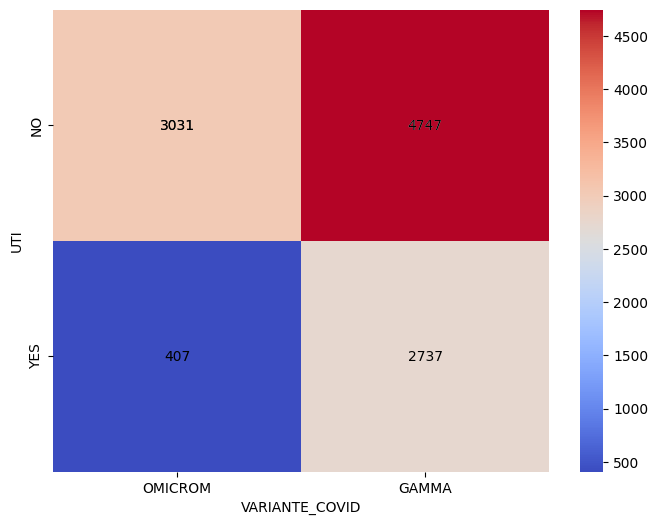

In [196]:
df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy() #gamma versus omicrom
df_temp = df_temp[df_temp['UTI'] != 'Missing']
df_temp['UTI'] = df_temp['UTI'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_GAMA_VS_OMICROM) # Gamma : 1 , Omicrom : 0

analyze_and_plot("UTI", "VARIANTE_COVID", df_temp, 1, 3,"GAMMA", "OMICROM")

Interpretation:

Exposed group : Patient has the gamma variant

Non-exposed group : Patient has the omicrom variant

Event Exposed group : Patient transferred to ICU

- a : Patient with gamma and transferred to ICU = 2737
- c : Patient with omicrom and transferred to ICU = 407
- b : Patient with gamma and not transferred to ICU = 4747
- d : Patient with omicrom and not transferred to ICU = 3031

$OR = \frac{a/b}{c/d} = 4,2938$ 

Therefore, the group of patients with the gamma variant has 4.2938 times the odds of being transferred to the ICU compared to omicron variant patients.


Logistic regression model EVOLUCAO:
Optimization terminated successfully.
         Current function value: 0.336707
         Iterations 7

Odds ratios for VARIANTE_COVID:
                      OR  Lower CI  Upper CI
VARIANTE_COVID  4.582796   3.81609  5.503543



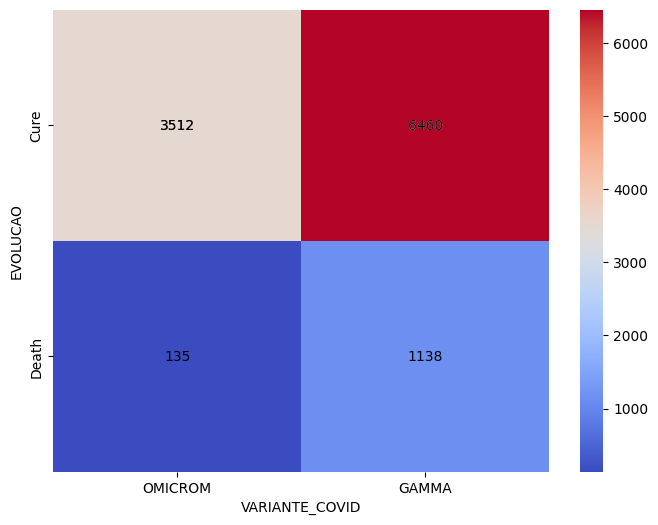

In [197]:
df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy() #gamma versus omicrom
df_temp = df_temp[df_temp['EVOLUCAO'] != 'Missing']
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_GAMA_VS_OMICROM) # Gamma : 1 , Omicrom : 0

analyze_and_plot("EVOLUCAO","VARIANTE_COVID", df_temp, 1, 3,"GAMMA", "OMICROM")

Interpretation:

Exposed group  : Patient has the gamma variant

Non-exposed group : Patient has the omicrom variant

Event : Patient died (True)

- a : Patient with gamma and died = 1138
- c : Patient with omicrom and died= 135
- b : Patient with gamma and cured = 6460
- d : Patient with omicrom and cured = 3512

$OR = \frac{a/b}{c/d} = 4,5827$ 

Therefore, the group of patients with the gamma variant has 4.5827 times the odds of being dead compared to omicron variant patients.

### Logistic Regression for Covid Variant (GAMA VS OMICROM) -Adjusted for age, gestational period, region, skin color, vaccination status

Logistic regression model UTI:
Optimization terminated successfully.
         Current function value: 0.543526
         Iterations 6

Odds ratios for VARIANTE_COVID:
                                      OR  Lower CI   Upper CI
Age_group[T.20-24]              1.067460  0.882376   1.291367
Age_group[T.25-29]              1.223049  1.018565   1.468585
Age_group[T.30-34]              1.541449  1.284331   1.850040
Age_group[T.35-39]              1.629284  1.347165   1.970482
Age_group[T.40+]                1.301620  1.040416   1.628401
VACINA_COV[T.No]                0.872745  0.788465   0.966035
VACINA_COV[T.Yes]               0.689275  0.588702   0.807029
C(Regiao_nome)[T.North]         1.003675  0.809226   1.244848
C(Regiao_nome)[T.Northeast]     1.338937  1.138535   1.574614
C(Regiao_nome)[T.South]         0.828244  0.696100   0.985473
C(Regiao_nome)[T.Southeast]     1.102708  0.955153   1.273058
C(CS_RACA)[T.Branca]            0.795072  0.464381   1.361252
C(CS_RACA)[T.Indigena]      

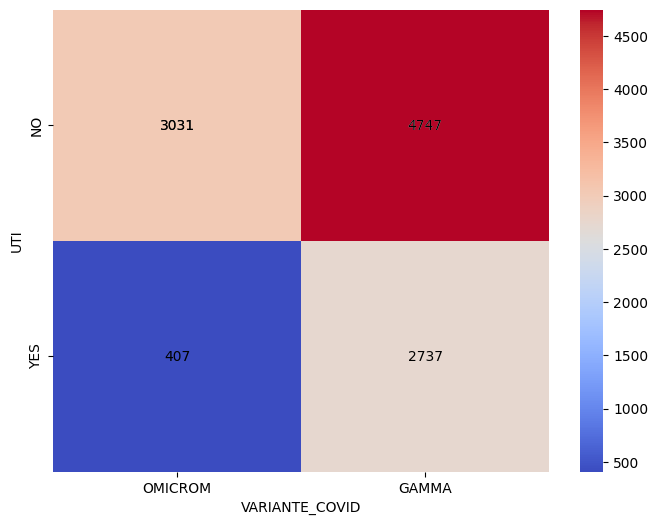

In [198]:
df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy() #gamma versus omicrom
df_temp = df_temp[df_temp['UTI'] != 'Missing']
df_temp['UTI'] = df_temp['UTI'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_GAMA_VS_OMICROM) # Gamma : 1 , Omicrom : 0

analyze_and_plot("UTI","VARIANTE_COVID",df_temp, 1 , 32 ,"GAMMA","OMICROM", "Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE")

Logistic regression model EVOLUCAO:
         Current function value: 0.305177
         Iterations: 35

Odds ratios for VARIANTE_COVID:
                                          OR  Lower CI  Upper CI
Age_group[T.20-24]              1.160685e+00  0.847768  1.589101
Age_group[T.25-29]              1.827915e+00  1.363007  2.451400
Age_group[T.30-34]              1.890232e+00  1.407889  2.537825
Age_group[T.35-39]              2.325654e+00  1.722441  3.140115
Age_group[T.40+]                3.600544e+00  2.614405  4.958651
VACINA_COV[T.No]                1.172953e+00  1.018371  1.351000
VACINA_COV[T.Yes]               6.126490e-01  0.483847  0.775738
C(Regiao_nome)[T.North]         1.710900e+00  1.279195  2.288297
C(Regiao_nome)[T.Northeast]     1.591402e+00  1.260941  2.008468
C(Regiao_nome)[T.South]         8.176525e-01  0.630193  1.060875
C(Regiao_nome)[T.Southeast]     1.121659e+00  0.907105  1.386960
C(CS_RACA)[T.Branca]            1.631848e+00  0.629089  4.232987
C(CS_RACA)[T.Indigen

c:\Users\lucas\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lucas\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


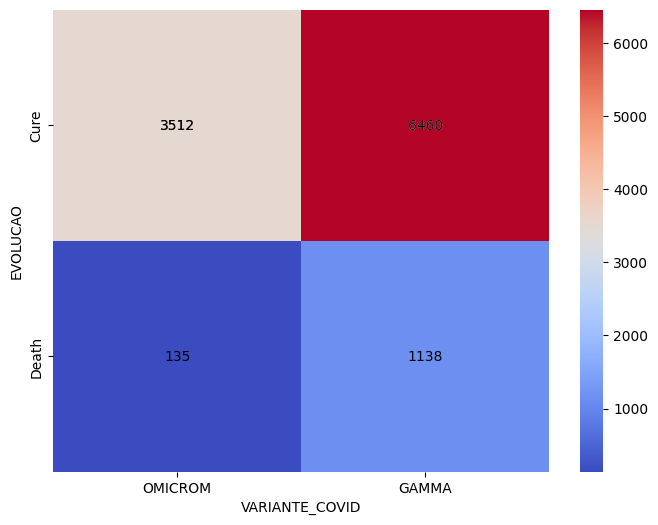

In [199]:
df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy() #gamma versus omicrom
df_temp = df_temp[df_temp['EVOLUCAO'] != 'Missing']
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_GAMA_VS_OMICROM) # Gamma : 1 , Omicrom : 0

analyze_and_plot("EVOLUCAO","VARIANTE_COVID",df_temp, 1 , 32 ,"GAMMA","OMICROM", "Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE")

Logistic regression for Covid Variant (DELTA VS OMICROM)

Logistic regression model UTI:
Optimization terminated successfully.
         Current function value: 0.408993
         Iterations 6

Odds ratios for VARIANTE_COVID:
                      OR  Lower CI  Upper CI
VARIANTE_COVID  4.109405   3.39264  4.977601



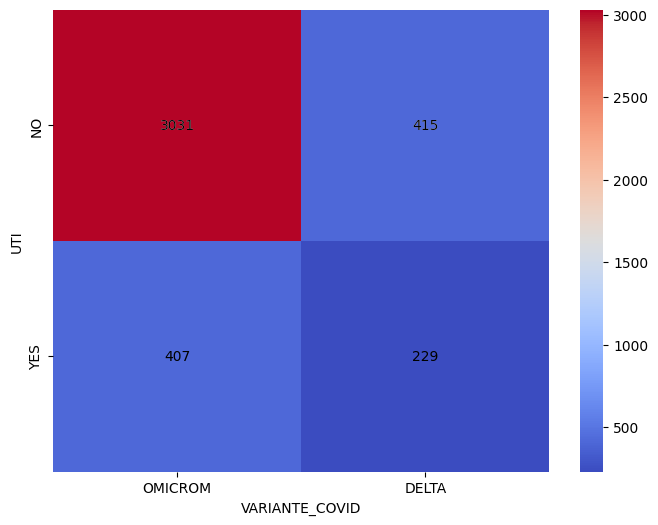

In [200]:
df_temp = df.loc[df['VARIANTE_COVID'] != 1].copy() #delta versus omicrom
df_temp = df_temp[df_temp['UTI'] != 'Missing']
df_temp['UTI'] = df_temp['UTI'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_DELTA_VS_OMICROM) # true : delta, false : omicrom

analyze_and_plot("UTI","VARIANTE_COVID",df_temp,1, 3,"DELTA", "OMICROM")

Logistic regression model EVOLUCAO:
Optimization terminated successfully.
         Current function value: 0.177635
         Iterations 7

Odds ratios for VARIANTE_COVID:
                      OR  Lower CI  Upper CI
VARIANTE_COVID  2.406257  1.730352  3.346182



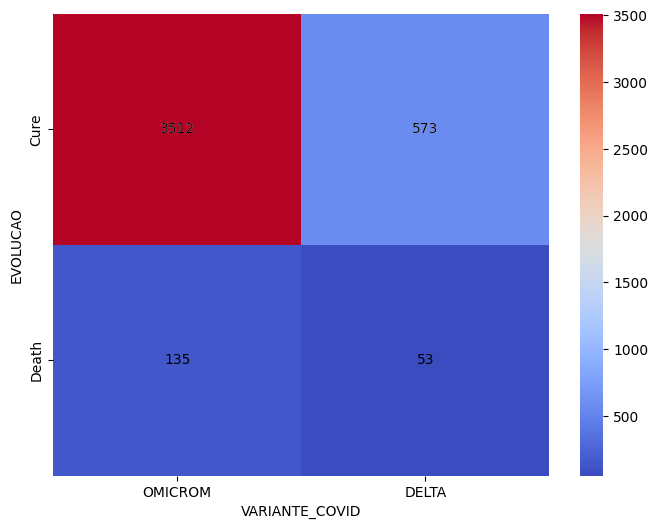

In [201]:
df_temp = df.loc[df['VARIANTE_COVID'] != 1].copy() #delta versus omicrom
df_temp = df_temp[df_temp['EVOLUCAO'] != 'Missing']
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_DELTA_VS_OMICROM) # true : delta, false : omicrom

analyze_and_plot("EVOLUCAO","VARIANTE_COVID",df_temp,1, 3,"DELTA","OMICROM")

Logistic Regression for Covid Variant (DELTA VS OMICROM) -Adjusted for age, gestational period, region, skin color, vaccination status

Logistic regression model UTI:
Optimization terminated successfully.
         Current function value: 0.385058
         Iterations 16

Odds ratios for VARIANTE_COVID:
                                          OR  Lower CI  Upper CI
Age_group[T.20-24]              1.002126e+00  0.723247  1.388538
Age_group[T.25-29]              9.400814e-01  0.677979  1.303512
Age_group[T.30-34]              1.094344e+00  0.781825  1.531785
Age_group[T.35-39]              1.263172e+00  0.878226  1.816848
Age_group[T.40+]                1.677812e+00  1.138868  2.471799
VACINA_COV[T.No]                1.039731e+00  0.649022  1.665644
VACINA_COV[T.Yes]               8.523379e-01  0.536515  1.354071
C(Regiao_nome)[T.North]         1.620400e+00  1.048350  2.504600
C(Regiao_nome)[T.Northeast]     2.005915e+00  1.374001  2.928452
C(Regiao_nome)[T.South]         1.229414e+00  0.856379  1.764944
C(Regiao_nome)[T.Southeast]     1.661863e+00  1.199319  2.302797
C(CS_RACA)[T.Branca]            9.409943e-01  0.30777

c:\Users\lucas\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


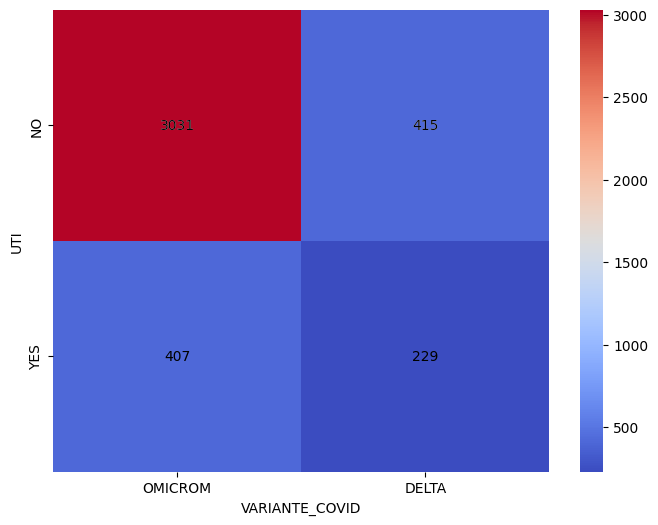

In [202]:
df_temp = df.loc[df['VARIANTE_COVID'] != 1].copy() #delta versus omicrom
df_temp = df_temp[df_temp['UTI'] != 'Missing']
df_temp['UTI'] = df_temp['UTI'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_DELTA_VS_OMICROM) # true : delta, false : omicrom

analyze_and_plot("UTI","VARIANTE_COVID",df_temp, 1 , 32 ,"DELTA","OMICROM", "Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE")

Logistic regression model EVOLUCAO:
         Current function value: 0.136546
         Iterations: 35

Odds ratios for VARIANTE_COVID:
                                          OR  Lower CI   Upper CI
Age_group[T.20-24]              1.365117e+00  0.644426   2.891789
Age_group[T.25-29]              1.696421e+00  0.823577   3.494325
Age_group[T.30-34]              1.501620e+00  0.693049   3.253539
Age_group[T.35-39]              1.564258e+00  0.680383   3.596360
Age_group[T.40+]                8.488583e+00  4.146521  17.377473
VACINA_COV[T.No]                1.391444e+00  0.568161   3.407693
VACINA_COV[T.Yes]               8.284076e-01  0.341130   2.011722
C(Regiao_nome)[T.North]         2.618608e+00  1.213912   5.648769
C(Regiao_nome)[T.Northeast]     3.040746e+00  1.518306   6.089770
C(Regiao_nome)[T.South]         7.854751e-01  0.384500   1.604608
C(Regiao_nome)[T.Southeast]     1.379586e+00  0.726616   2.619344
C(CS_RACA)[T.Branca]            5.589916e+06  0.000000        inf
C(CS_RA

c:\Users\lucas\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lucas\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


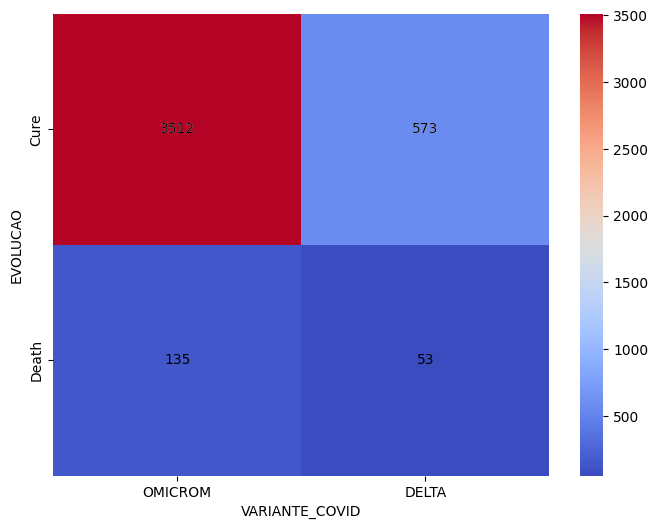

In [203]:
df_temp = df.loc[df['VARIANTE_COVID'] != 1].copy() #delta versus omicrom
df_temp = df_temp[df_temp['EVOLUCAO'] != 'Missing']
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_DELTA_VS_OMICROM) # true : delta, false : omicrom

analyze_and_plot("EVOLUCAO","VARIANTE_COVID",df_temp, 1 , 32 ,"DELTA","OMICROM", "Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE")

Logistic Regression for Covid Variant (GAMMA VS DELTA)

Logistic regression model UTI:
Optimization terminated successfully.
         Current function value: 0.656176
         Iterations 4

Odds ratios for VARIANTE_COVID:
                      OR  Lower CI  Upper CI
VARIANTE_COVID  1.044884  0.883244  1.236106



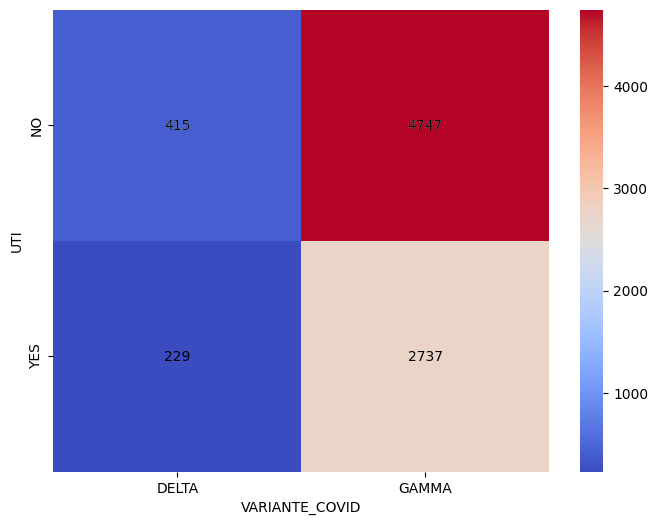

In [204]:
df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()#Gama vs delta
df_temp = df_temp[df_temp['UTI'] != 'Missing']
df_temp['UTI'] = df_temp['UTI'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_GAMA_VS_DELTA) # true : Gama, false : Delta

analyze_and_plot("UTI","VARIANTE_COVID", df_temp, 1, 3,"GAMMA", "DELTA")

Logistic regression model EVOLUCAO:
Optimization terminated successfully.
         Current function value: 0.412250
         Iterations 6

Odds ratios for VARIANTE_COVID:
                      OR  Lower CI  Upper CI
VARIANTE_COVID  1.904533  1.427424  2.541114



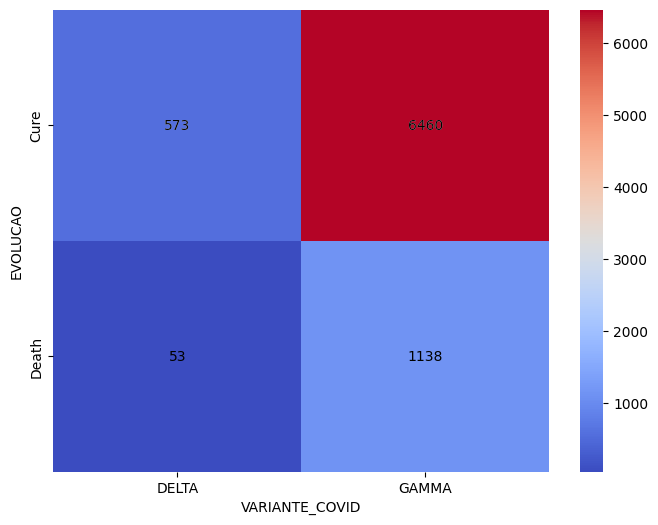

In [205]:
df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()#Gama vs delta
df_temp = df_temp[df_temp['EVOLUCAO'] != 'Missing']
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_GAMA_VS_DELTA) # true : Gama, false : Delta


analyze_and_plot("EVOLUCAO","VARIANTE_COVID", df_temp, 1, 3,"GAMMA", "DELTA")

Logistic Regression for Covid Variant (GAMMA VS DELTA)-Adjusted for age, gestational period, region, skin color, vaccination status

Logistic regression model UTI:
         Current function value: 0.630275
         Iterations: 35

Odds ratios for VARIANTE_COVID:
                                          OR  Lower CI  Upper CI
Age_group[T.20-24]              1.115038e+00  0.906954  1.370862
Age_group[T.25-29]              1.330893e+00  1.092394  1.621464
Age_group[T.30-34]              1.697145e+00  1.393617  2.066782
Age_group[T.35-39]              1.786422e+00  1.456028  2.191788
Age_group[T.40+]                1.246960e+00  0.976661  1.592066
VACINA_COV[T.No]                8.863587e-01  0.800050  0.981978
VACINA_COV[T.Yes]               5.814372e-01  0.488229  0.692439
C(Regiao_nome)[T.North]         8.144334e-01  0.649427  1.021365
C(Regiao_nome)[T.Northeast]     1.244915e+00  1.052462  1.472560
C(Regiao_nome)[T.South]         9.154530e-01  0.764155  1.096706
C(Regiao_nome)[T.Southeast]     1.136221e+00  0.979387  1.318170
C(CS_RACA)[T.Branca]            7.119682e-01  0.391263  1.295546
C(CS_RACA)[T.Indigena]   

c:\Users\lucas\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lucas\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


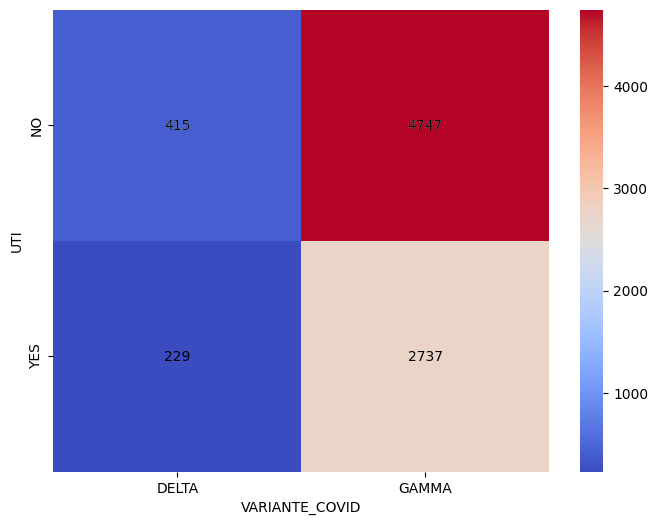

In [206]:
df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()#Gama vs delta
df_temp = df_temp[df_temp['UTI'] != 'Missing']
df_temp['UTI'] = df_temp['UTI'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_GAMA_VS_DELTA) # true : Gama, false : Delta

analyze_and_plot("UTI","VARIANTE_COVID",df_temp, 1 , 32 ,"GAMMA", "DELTA", "Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE")

Logistic regression model EVOLUCAO:
         Current function value: 0.377960
         Iterations: 35

Odds ratios for VARIANTE_COVID:
                                      OR      Lower CI      Upper CI
Age_group[T.20-24]              1.090183  7.906328e-01  1.503224e+00
Age_group[T.25-29]              1.700735  1.260800e+00  2.294178e+00
Age_group[T.30-34]              1.795229  1.330303e+00  2.422642e+00
Age_group[T.35-39]              2.281421  1.681050e+00  3.096208e+00
Age_group[T.40+]                2.517737  1.795392e+00  3.530706e+00
VACINA_COV[T.No]                1.221887  1.061420e+00  1.406614e+00
VACINA_COV[T.Yes]               0.460429  3.480243e-01  6.091385e-01
C(Regiao_nome)[T.North]         1.476856  1.093871e+00  1.993931e+00
C(Regiao_nome)[T.Northeast]     1.465539  1.156885e+00  1.856541e+00
C(Regiao_nome)[T.South]         0.853001  6.549084e-01  1.111011e+00
C(Regiao_nome)[T.Southeast]     1.118345  9.030548e-01  1.384961e+00
C(CS_RACA)[T.Branca]            1.336

c:\Users\lucas\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


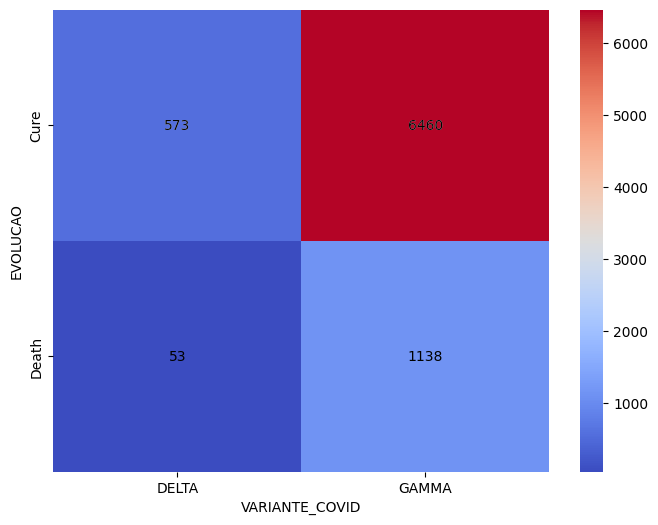

In [207]:
df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()#Gama vs delta
df_temp = df_temp[df_temp['EVOLUCAO'] != 'Missing']
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].astype(int)
df_temp.reset_index(inplace = True, drop = True)
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_GAMA_VS_DELTA) # true : Gama, false : Delta

analyze_and_plot("EVOLUCAO", "VARIANTE_COVID",df_temp, 1 , 32 ,"GAMMA", "DELTA" ,"Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE")

### Logistic regression for Covid Variant (DELTA VS OMICROM) for each region

In [208]:
df_temp = df.loc[df['VARIANTE_COVID'] != 1].copy()  
df_temp.reset_index(inplace=True, drop=True)

#create a variable
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * np.nan

lista_obito = [1, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Individuals who were admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 1):  # Individuals admitted to the ICU who did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0
        
df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
df_temp = df_temp[df_temp['UTI_EVOLUCAO'] != 'Missing']

df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_DELTA_VS_OMICROM) # true : delta, false : omicrom

C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\3489347484.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\3489347484.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)


In [209]:
df_temp['UTI_EVOLUCAO'].value_counts()

UTI_EVOLUCAO
0.0    3194
1.0     650
Name: count, dtype: int64

In [210]:
#delimit the dataset for each region

df_temp_sudeste = df_temp.loc[df_temp['Regiao_nome'] == 'Southeast']
df_temp_Sul = df_temp.loc[df_temp['Regiao_nome'] == 'South']
df_temp_Nordeste = df_temp.loc[df_temp['Regiao_nome'] == 'Northeast']
df_temp_Centro_oeste = df_temp.loc[df_temp['Regiao_nome'] == 'Midwest']
df_temp_Norte = df_temp.loc[df_temp['Regiao_nome'] == 'North']

,OR,Lower CI,Upper CI
Southeast,5.48,3.95,7.60
South,6.59,4.49,9.69
Northeast,1.62,0.91,2.87
Midwest,4.13,2.41,7.10
North,1.24,0.62,2.47
Brazil,3.93,3.23,4.77


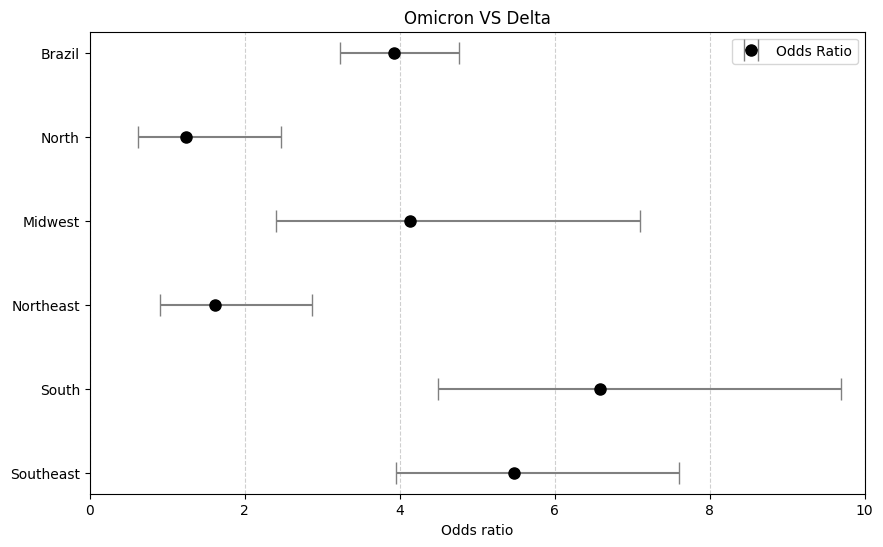


Number of variant cases for each region:
VARIANTE_COVID  OMICRON  DELTA
Regiao_nome                   
Midwest             347    115
North               199     59
Northeast           316     65
South               995    164
Southeast          1402    182


In [211]:
region_list = ['Southeast', 'South', 'Northeast', 'Midwest', 'North', 'Brazil']
data_list = [df_temp_sudeste, df_temp_Sul, df_temp_Nordeste, df_temp_Centro_oeste, df_temp_Norte, df_temp]
odds_ratios = []
lowerCI = []
upperCI = []

# Loop through each region and perform logistic regression
for region, data_ in zip(region_list, data_list):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit("VARIANTE_COVID ~ UTI_EVOLUCAO", data=data_).fit(disp=False)
        odds_ratios.append(np.exp(model.params[1]))
        lowerCI.append(np.exp(model.conf_int()[0][1]))
        upperCI.append(np.exp(model.conf_int()[1][1]))

# Create a DataFrame to store odds ratios and confidence intervals
or_ = pd.DataFrame({"OR": odds_ratios, "Lower CI": lowerCI, "Upper CI": upperCI})
or_.index = region_list
or_ = np.round(or_, 2)
print()
display(or_)

# Plotting the graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(or_['OR'], or_.index, xerr=[or_['OR'] - or_['Lower CI'], or_['Upper CI'] - or_['OR']],
            fmt='o', markersize=8, capsize=8, color='black', ecolor='gray')

# Adding labels and title to the graph
ax.set_xlabel("Odds ratio")
ax.set_title('Omicron VS Delta')
ax.set_xlim(0, 10)

# Adding a legend for better understanding
ax.legend(['Odds Ratio'])

# Adding a grid to the x-axis for better readability
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

# Additional information about variant cases for each region
crosstab_delta_omicrom_REGION = pd.crosstab(df_temp['Regiao_nome'], df_temp['VARIANTE_COVID'])
crosstab_delta_omicrom_REGION.rename(columns={0: "OMICRON", 1: "DELTA"}, inplace=True)
print()
print("Number of variant cases for each region:")
print(crosstab_delta_omicrom_REGION)

Logistic regression for Covid Variant (GAMA VS OMICROM) for each region

In [212]:
df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy()  
df_temp.reset_index(inplace=True, drop=True)

#create a variable
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * np.nan

lista_obito = [1, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Individuals who were admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 1):  # Individuals admitted to the ICU who did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0
        
df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
df_temp = df_temp[df_temp['UTI_EVOLUCAO'] != 'Missing']

df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_GAMA_VS_OMICROM) # true : gamma, false : omicrom

C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\364441115.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\364441115.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)


In [213]:
df_temp['UTI_EVOLUCAO'].value_counts()

UTI_EVOLUCAO
0.0    7065
1.0    3268
Name: count, dtype: int64

In [214]:
#delimit the dataset for each region

df_temp_sudeste = df_temp.loc[df_temp['Regiao_nome'] == 'Southeast']
df_temp_Sul = df_temp.loc[df_temp['Regiao_nome'] == 'South']
df_temp_Nordeste = df_temp.loc[df_temp['Regiao_nome'] == 'Northeast']
df_temp_Centro_oeste = df_temp.loc[df_temp['Regiao_nome'] == 'Midwest']
df_temp_Norte = df_temp.loc[df_temp['Regiao_nome'] == 'North']

,OR,Lower CI,Upper CI
Southeast,4.44,3.76,5.25
South,5.70,4.44,7.31
Northeast,2.43,1.83,3.21
Midwest,5.98,4.07,8.79
North,2.27,1.52,3.37
Brazil,4.39,3.93,4.91


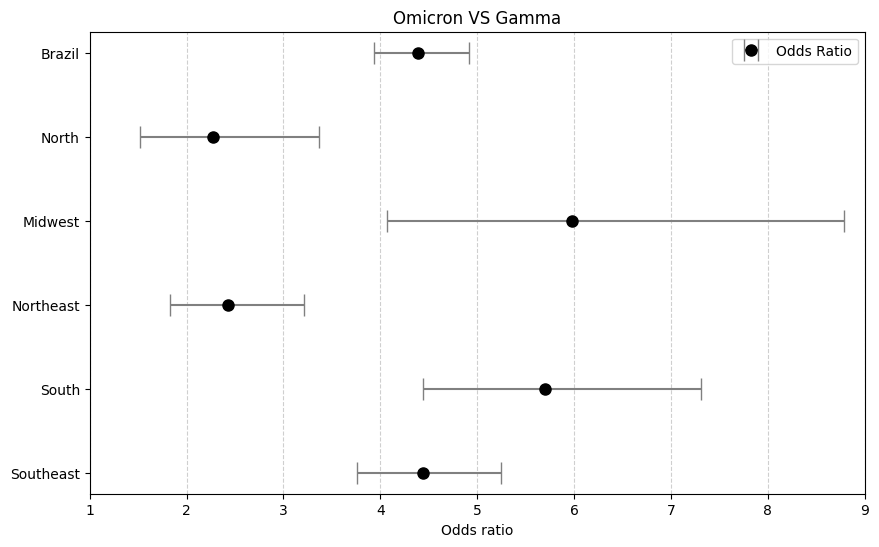


Number of variant cases for each region:
VARIANTE_COVID  OMICRON  GAMMA
Regiao_nome                   
Midwest             347    995
North               199    449
Northeast           316   1257
South               995   1245
Southeast          1402   3128


In [215]:
region_list = ['Southeast', 'South', 'Northeast', 'Midwest', 'North', 'Brazil']
data_list = [df_temp_sudeste, df_temp_Sul, df_temp_Nordeste, df_temp_Centro_oeste, df_temp_Norte, df_temp]
odds_ratios = []
lowerCI = []
upperCI = []

# Loop through each region and perform logistic regression
for region, data_ in zip(region_list, data_list):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit("VARIANTE_COVID ~ UTI_EVOLUCAO", data=data_).fit(disp=False)
        odds_ratios.append(np.exp(model.params[1]))
        lowerCI.append(np.exp(model.conf_int()[0][1]))
        upperCI.append(np.exp(model.conf_int()[1][1]))

# Create a DataFrame to store odds ratios and confidence intervals
or_ = pd.DataFrame({"OR": odds_ratios, "Lower CI": lowerCI, "Upper CI": upperCI})
or_.index = region_list
or_ = np.round(or_, 2)
print()
display(or_)

# Plotting the graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(or_['OR'], or_.index, xerr=[or_['OR'] - or_['Lower CI'], or_['Upper CI'] - or_['OR']],
            fmt='o', markersize=8, capsize=8, color='black', ecolor='gray')

# Adding labels and title to the graph
ax.set_xlabel("Odds ratio")
ax.set_title('Omicron VS Gamma')
ax.set_xlim(1, 9)

# Adding a legend for better understanding
ax.legend(['Odds Ratio'])

# Adding a grid to the x-axis for better readability
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

# Additional information about variant cases for each region
crosstab_gamma_omicrom_REGION = pd.crosstab(df_temp['Regiao_nome'], df_temp['VARIANTE_COVID'])
crosstab_gamma_omicrom_REGION.rename(columns={0: "OMICRON", 1: "GAMMA"}, inplace=True)
print()
print("Number of variant cases for each region:")
print(crosstab_gamma_omicrom_REGION)

Logistic regression for Covid Variant (GAMMA VS DELTA) for each region

In [216]:
df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()  
df_temp.reset_index(inplace=True, drop=True)

#create a variable
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * np.nan

lista_obito = [1, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Individuals who were admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 1):  # Individuals admitted to the ICU who did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0
        
df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
df_temp = df_temp[df_temp['UTI_EVOLUCAO'] != 'Missing']

df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(DIC_GAMA_VS_DELTA) # true : gamma, false : delta

C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\3424581190.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\3424581190.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)


In [217]:
#delimit the dataset for each region

df_temp_sudeste = df_temp.loc[df_temp['Regiao_nome'] == 'Southeast']
df_temp_Sul = df_temp.loc[df_temp['Regiao_nome'] == 'South']
df_temp_Nordeste = df_temp.loc[df_temp['Regiao_nome'] == 'Northeast']
df_temp_Centro_oeste = df_temp.loc[df_temp['Regiao_nome'] == 'Midwest']
df_temp_Norte = df_temp.loc[df_temp['Regiao_nome'] == 'North']

,OR,Lower CI,Upper CI
Southeast,0.81,0.60,1.09
South,0.86,0.62,1.21
Northeast,1.50,0.89,2.54
Midwest,1.45,0.95,2.20
North,1.83,0.98,3.44
Brazil,1.12,0.94,1.33


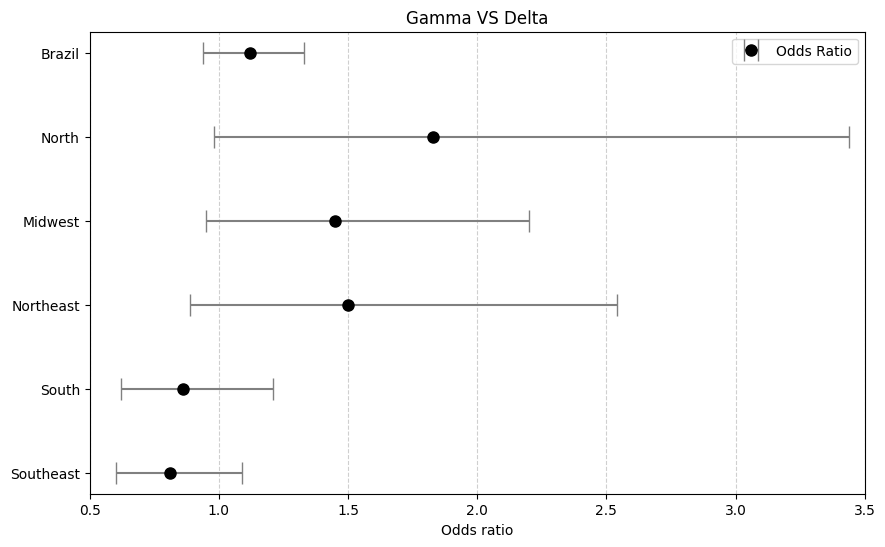


Number of variant cases for each region:
VARIANTE_COVID  DELTA  GAMMA
Regiao_nome                 
Midwest           115    995
North              59    449
Northeast          65   1257
South             164   1245
Southeast         182   3128


In [218]:
region_list = ['Southeast', 'South', 'Northeast', 'Midwest', 'North', 'Brazil']
data_list = [df_temp_sudeste, df_temp_Sul, df_temp_Nordeste, df_temp_Centro_oeste, df_temp_Norte, df_temp]
odds_ratios = []
lowerCI = []
upperCI = []

# Loop through each region and perform logistic regression
for region, data_ in zip(region_list, data_list):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit("VARIANTE_COVID ~ UTI_EVOLUCAO", data=data_).fit(disp=False)
        odds_ratios.append(np.exp(model.params[1]))
        lowerCI.append(np.exp(model.conf_int()[0][1]))
        upperCI.append(np.exp(model.conf_int()[1][1]))

# Create a DataFrame to store odds ratios and confidence intervals
or_ = pd.DataFrame({"OR": odds_ratios, "Lower CI": lowerCI, "Upper CI": upperCI})
or_.index = region_list
or_ = np.round(or_, 2)
print()
display(or_)

# Plotting the graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(or_['OR'], or_.index, xerr=[or_['OR'] - or_['Lower CI'], or_['Upper CI'] - or_['OR']],
            fmt='o', markersize=8, capsize=8, color='black', ecolor='gray')

# Adding labels and title to the graph
ax.set_xlabel("Odds ratio")
ax.set_title('Gamma VS Delta')
ax.set_xlim(0.5, 3.5)

# Adding a legend for better understanding
ax.legend(['Odds Ratio'])

# Adding a grid to the x-axis for better readability
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

# Additional information about variant cases for each region
crosstab_gamma_delta_REGION = pd.crosstab(df_temp['Regiao_nome'], df_temp['VARIANTE_COVID'])
crosstab_gamma_delta_REGION.rename(columns={0: "DELTA", 1: "GAMMA"}, inplace=True)
print()
print("Number of variant cases for each region:")
print(crosstab_gamma_delta_REGION)

## Table 3: Association of Clinical features of SARS-CoV-2 infection at admission and adverse maternal outcomes, by SARS-COV-2 VOCs,  in Brazil and regions.  (one table fo each outcome ICU admission, Intubation, maternal death).

Logistic regression for ICU admission

In [219]:
vars = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO','DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA']
colunas = ['UTI', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA']

In [220]:
#df['UTI'] = df['UTI'].replace({"True": 1, "False": 2}) # 1 : YES , 2 : NO
df_temp = df.copy()  
for coluna in colunas:
    df_temp = df_temp.loc[df_temp[coluna] != 'Missing']
    
dic = {1:1, 2:0}
    
df_temp[colunas] = df_temp[colunas].applymap(lambda x: dic.get(x, x))

df_temp_gama = df_temp.loc[df_temp['VARIANTE_COVID'] == 1].copy()  

df_temp_delta = df_temp.loc[df_temp['VARIANTE_COVID'] == 2].copy()  

df_temp_omicrom = df_temp.loc[df_temp['VARIANTE_COVID'] == 3].copy()  

C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\3723308462.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_temp[colunas] = df_temp[colunas].applymap(lambda x: dic.get(x, x))


In [221]:
#creating Logistic Regression model only for p-values
models = {}
p_values = {}
for i, feature in enumerate(vars):
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        models[f"model_{i}"] = smf.logit(f"UTI ~ {feature}", data=df_temp).fit(disp=0)
        p_values[f"p_value_{i}"] = models[f"model_{i}"].pvalues[1]

lista_p_values = list(p_values.values())
lista_p_values = np.round(lista_p_values,4)

# Logistic Regression - Gamma

odds_ratios_gama = []
lowerCI_gama= []
upperCI_gama = []

for i, var in enumerate(vars):
    formula = f"UTI ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_temp_gama).fit(disp=0)

        odds_ratios_gama.append(np.exp(model.params[1]))
        lowerCI_gama.append(np.exp(model.conf_int()[0][1]))
        upperCI_gama.append(np.exp(model.conf_int()[1][1]))

or_gama = pd.DataFrame({"OR": odds_ratios_gama,"Lower CI": lowerCI_gama,"Upper CI": upperCI_gama})
or_gama.index = vars
or_gama = np.round(or_gama,2)
or_gama = or_gama.astype(str)
or_gama['OR GAMA (95% CI)'] = or_gama.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_gama.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Logistic Regression - Delta

odds_ratios_delta = []
lowerCI_delta= []
upperCI_delta = []

for i, var in enumerate(vars):
    formula = f"UTI ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_temp_delta).fit(disp=0)

        odds_ratios_delta.append(np.exp(model.params[1]))
        lowerCI_delta.append(np.exp(model.conf_int()[0][1]))
        upperCI_delta.append(np.exp(model.conf_int()[1][1]))

or_delta = pd.DataFrame({"OR": odds_ratios_delta,"Lower CI": lowerCI_delta,"Upper CI": upperCI_delta})
or_delta.index = vars
or_delta = np.round(or_delta,2)
or_delta = or_delta.astype(str)
or_delta['OR DELTA (95% CI)'] = or_delta.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_delta.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Logistic Regression - Omicrom

odds_ratios_omicrom = []
lowerCI_omicrom = []
upperCI_omicrom = []

for i, var in enumerate(vars):
    formula = f"UTI ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_temp_omicrom).fit(disp=0)

        odds_ratios_omicrom.append(np.exp(model.params[1]))
        lowerCI_omicrom.append(np.exp(model.conf_int()[0][1]))
        upperCI_omicrom.append(np.exp(model.conf_int()[1][1]))

or_omicrom = pd.DataFrame({"OR": odds_ratios_omicrom,"Lower CI": lowerCI_omicrom,"Upper CI": upperCI_omicrom})
or_omicrom.index = vars
or_omicrom = np.round(or_omicrom,2)
or_omicrom = or_omicrom.astype(str)
or_omicrom['OR OMICROM (95% CI)'] = or_omicrom.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_omicrom.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

or_UTI = pd.DataFrame({"OR GAMA (95% CI)":or_gama['OR GAMA (95% CI)'],"OR DELTA (95% CI)": or_delta['OR DELTA (95% CI)'],"OR OMICROM (95% CI)": or_omicrom['OR OMICROM (95% CI)']},index = vars)
or_UTI['p-value'] = list(lista_p_values)
or_UTI

,OR GAMA (95% CI),OR DELTA (95% CI),OR OMICROM (95% CI),p-value
FEBRE,1.26 (1.12 - 1.41),1.35 (0.92 - 2.0),1.73 (1.33 - 2.24),0.0000
TOSSE,1.38 (1.21 - 1.58),1.01 (0.67 - 1.53),1.24 (0.96 - 1.62),0.0000
GARGANTA,0.8 (0.69 - 0.92),0.91 (0.57 - 1.44),0.69 (0.5 - 0.96),0.0000
DISPNEIA,4.3 (3.71 - 4.97),3.61 (2.37 - 5.5),5.26 (4.02 - 6.88),0.0000
DESC_RESP,2.89 (2.56 - 3.27),3.58 (2.38 - 5.37),4.25 (3.26 - 5.55),0.0000
SATURACAO,4.01 (3.53 - 4.54),5.36 (3.52 - 8.16),6.79 (5.15 - 8.95),0.0000
DIARREIA,0.74 (0.6 - 0.9),0.89 (0.4 - 1.98),1.62 (0.94 - 2.77),0.5713
VOMITO,0.72 (0.59 - 0.87),1.15 (0.57 - 2.32),1.31 (0.84 - 2.04),0.0971
DOR_ABD,0.7 (0.56 - 0.87),0.81 (0.37 - 1.79),1.34 (0.86 - 2.09),0.0294
FADIGA,1.34 (1.18 - 1.52),1.68 (1.08 - 2.61),2.12 (1.56 - 2.87),0.0000


Logistic regression for Death

In [222]:
df['EVOLUCAO'].value_counts()

EVOLUCAO
0          10545
1           1326
Missing      820
3.0           30
Name: count, dtype: int64

In [223]:
df_temp = df.copy()  
for coluna in colunas:
    df_temp = df_temp.loc[df_temp[coluna] != 'Missing']
    
dic = {1:1, 2:0}
    
df_temp[colunas] = df_temp[colunas].applymap(lambda x: dic.get(x, x))

dic_evolucao = {1:1 ,0:0, 3:1, "Missing" : "Missing"} 
df_temp['EVOLUCAO']=df_temp['EVOLUCAO'].map(dic_evolucao)
df_temp = df_temp[df_temp['EVOLUCAO'] != 'Missing']
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].astype(int)

df_temp_gama = df_temp.loc[df_temp['VARIANTE_COVID'] == 1].copy()  

df_temp_delta = df_temp.loc[df_temp['VARIANTE_COVID'] == 2].copy()  

df_temp_omicrom = df_temp.loc[df_temp['VARIANTE_COVID'] == 3].copy()   

C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\2616686092.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_temp[colunas] = df_temp[colunas].applymap(lambda x: dic.get(x, x))


In [224]:
#creating Logistic Regression model only for p-values
models = {}
p_values = {}
for i, feature in enumerate(vars):
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        models[f"model_{i}"] = smf.logit(f"EVOLUCAO ~ {feature}", data=df_temp).fit(disp=0)
        p_values[f"p_value_{i}"] = models[f"model_{i}"].pvalues[1]

lista_p_values = list(p_values.values())
lista_p_values = np.round(lista_p_values,4)

# Logistic Regression - Gamma

odds_ratios_gama = []
lowerCI_gama= []
upperCI_gama = []

for i, var in enumerate(vars):
    formula = f"EVOLUCAO ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_temp_gama).fit(disp=0)

        odds_ratios_gama.append(np.exp(model.params[1]))
        lowerCI_gama.append(np.exp(model.conf_int()[0][1]))
        upperCI_gama.append(np.exp(model.conf_int()[1][1]))

or_gama = pd.DataFrame({"OR": odds_ratios_gama,"Lower CI": lowerCI_gama,"Upper CI": upperCI_gama})
or_gama.index = vars
or_gama = np.round(or_gama,2)
or_gama = or_gama.astype(str)
or_gama['OR GAMA (95% CI)'] = or_gama.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_gama.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Logistic Regression - Delta

odds_ratios_delta = []
lowerCI_delta= []
upperCI_delta = []

for i, var in enumerate(vars):
    formula = f"EVOLUCAO ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_temp_delta).fit(disp=0)

        odds_ratios_delta.append(np.exp(model.params[1]))
        lowerCI_delta.append(np.exp(model.conf_int()[0][1]))
        upperCI_delta.append(np.exp(model.conf_int()[1][1]))

or_delta = pd.DataFrame({"OR": odds_ratios_delta,"Lower CI": lowerCI_delta,"Upper CI": upperCI_delta})
or_delta.index = vars
or_delta = np.round(or_delta,2)
or_delta = or_delta.astype(str)
or_delta['OR DELTA (95% CI)'] = or_delta.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_delta.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Logistic Regression - Omicrom

odds_ratios_omicrom = []
lowerCI_omicrom = []
upperCI_omicrom = []

for i, var in enumerate(vars):
    formula = f"EVOLUCAO ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_temp_omicrom).fit(disp=0)

        odds_ratios_omicrom.append(np.exp(model.params[1]))
        lowerCI_omicrom.append(np.exp(model.conf_int()[0][1]))
        upperCI_omicrom.append(np.exp(model.conf_int()[1][1]))

or_omicrom = pd.DataFrame({"OR": odds_ratios_omicrom,"Lower CI": lowerCI_omicrom,"Upper CI": upperCI_omicrom})
or_omicrom.index = vars
or_omicrom = np.round(or_omicrom,2)
or_omicrom = or_omicrom.astype(str)
or_omicrom['OR OMICROM (95% CI)'] = or_omicrom.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_omicrom.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

or_OBITO = pd.DataFrame({"OR GAMA (95% CI)":or_gama['OR GAMA (95% CI)'],"OR DELTA (95% CI)": or_delta['OR DELTA (95% CI)'],"OR OMICROM (95% CI)": or_omicrom['OR OMICROM (95% CI)']},index = vars)
or_OBITO['p-value'] = list(lista_p_values)
or_OBITO

,OR GAMA (95% CI),OR DELTA (95% CI),OR OMICROM (95% CI),p-value
FEBRE,1.26 (1.08 - 1.48),1.44 (0.72 - 2.86),2.33 (1.56 - 3.48),0.0000
TOSSE,1.17 (0.98 - 1.4),0.94 (0.45 - 1.93),1.74 (1.14 - 2.66),0.0000
GARGANTA,1.06 (0.87 - 1.28),0.73 (0.31 - 1.71),0.4 (0.22 - 0.73),0.1897
DISPNEIA,3.52 (2.86 - 4.34),3.59 (1.6 - 8.06),10.75 (6.76 - 17.07),0.0000
DESC_RESP,2.54 (2.15 - 3.0),3.46 (1.66 - 7.23),8.15 (5.29 - 12.54),0.0000
SATURACAO,3.63 (3.04 - 4.33),6.18 (2.83 - 13.53),15.42 (9.86 - 24.13),0.0000
DIARREIA,0.84 (0.64 - 1.1),1.31 (0.38 - 4.56),3.2 (1.68 - 6.07),0.2785
VOMITO,0.72 (0.54 - 0.96),2.07 (0.75 - 5.72),1.43 (0.75 - 2.72),0.3068
DOR_ABD,0.79 (0.59 - 1.07),1.17 (0.34 - 4.03),1.63 (0.87 - 3.04),0.5219
FADIGA,1.04 (0.88 - 1.23),0.88 (0.39 - 2.0),2.19 (1.4 - 3.43),0.0011


### To make a comparison with the general vaccination rate among cases, showing that the most severe cases were not vaccinated 

Analysis comparing vaccination coverage among cases of maternal death and ICU admission vs. patients who did not have either outcome for Gamma

In [225]:
df_temp = df.loc[df['VARIANTE_COVID'] == 1].copy()  #Gamma
df_temp.reset_index(inplace=True, drop=True)

#create a variable
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * np.nan

lista_obito = [1, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Individuals who were admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 1):  # Individuals admitted to the ICU who did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0
        
df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
df_temp = df_temp[df_temp['UTI_EVOLUCAO'] != 'Missing']
df_temp['UTI_EVOLUCAO'] = df_temp['UTI_EVOLUCAO'].astype(int)
df_temp = df_temp[df_temp['VACINA_COV'] != 'Missing']
df_temp['VACINA_COV'] = df_temp['VACINA_COV'].replace({"No": 0, "Yes": 1}) 
df_temp.reset_index(inplace=True, drop=True)

C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\3884267023.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\3884267023.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
C:\Users\

Logistic regression model:
                           Logit Regression Results                           
Dep. Variable:           UTI_EVOLUCAO   No. Observations:                 4347
Model:                          Logit   Df Residuals:                     4345
Method:                           MLE   Df Model:                            1
Date:                Sun, 19 May 2024   Pseudo R-squ.:                0.002151
Time:                        11:30:05   Log-Likelihood:                -2892.9
converged:                       True   LL-Null:                       -2899.2
Covariance Type:            nonrobust   LLR p-value:                 0.0004125
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4200      0.033    -12.548      0.000      -0.486      -0.354
VACINA_COV    -0.3222      0.092     -3.487      0.000      -0.503      -0.141

Odds ratios for VACINA_C

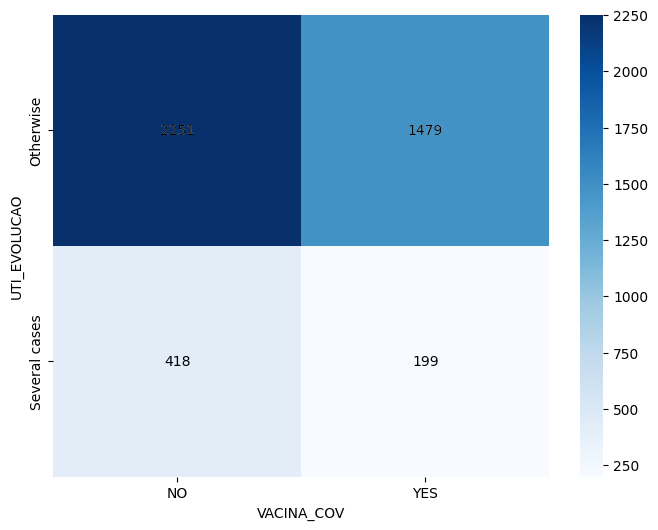

In [226]:
# Logistic regression model
print(f"Logistic regression model:")
model = smf.logit("UTI_EVOLUCAO ~ VACINA_COV" , data=df_temp).fit(disp=False)
print(model.summary())

# Odds ratios
odds_ratios = pd.DataFrame(
    {
        "OR": model.params,
        "Lower CI": model.conf_int()[0],
        "Upper CI": model.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios = odds_ratios.iloc[1:3]

# Plot odds ratios
print()
print(f"Odds ratios for VACINA_COV:")
print(odds_ratios)
print()

# Crosstab
crosstab = pd.crosstab(df_temp["VACINA_COV"], df_temp["UTI_EVOLUCAO"])

crosstab.rename(columns={1: "YES", 0: "NO"}, index={0: "Otherwise", 1: "Several cases"}, inplace=True)

plt.figure(figsize=(8, 6))
ax = sn.heatmap(crosstab, annot=True, fmt="d", cmap="Blues", cbar=True)

# Add values to each cell
for i in range(len(crosstab)):
    for j in range(len(crosstab.columns)):
        ax.text(j + 0.5, i + 0.5, crosstab.iloc[i, j],
                ha='center', va='center', color='black', fontsize=10)

plt.xlabel("VACINA_COV")
plt.ylabel("UTI_EVOLUCAO")
plt.show()

Analysis comparing vaccination coverage among cases of maternal death and ICU admission vs. patients who did not have either outcome for Delta

In [227]:
df_temp = df.loc[df['VARIANTE_COVID'] == 2].copy()  #Delta
df_temp.reset_index(inplace=True, drop=True)

#create a variable
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * np.nan

lista_obito = [1, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Individuals who were admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 1):  # Individuals admitted to the ICU who did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0
        
df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
df_temp = df_temp[df_temp['UTI_EVOLUCAO'] != 'Missing']
df_temp['UTI_EVOLUCAO'] = df_temp['UTI_EVOLUCAO'].astype(int)
df_temp = df_temp[df_temp['VACINA_COV'] != 'Missing']
df_temp['VACINA_COV'] = df_temp['VACINA_COV'].replace({"No": 0, "Yes": 1}) 
df_temp.reset_index(inplace=True, drop=True)

C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\2407677451.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\2407677451.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
C:\Users\

Logistic regression model:
                           Logit Regression Results                           
Dep. Variable:           UTI_EVOLUCAO   No. Observations:                  545
Model:                          Logit   Df Residuals:                      543
Method:                           MLE   Df Model:                            1
Date:                Sun, 19 May 2024   Pseudo R-squ.:                 0.01142
Time:                        11:30:05   Log-Likelihood:                -355.21
converged:                       True   LL-Null:                       -359.32
Covariance Type:            nonrobust   LLR p-value:                  0.004174
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2672      0.126     -2.119      0.034      -0.514      -0.020
VACINA_COV    -0.5102      0.179     -2.855      0.004      -0.861      -0.160

Odds ratios for VACINA_C

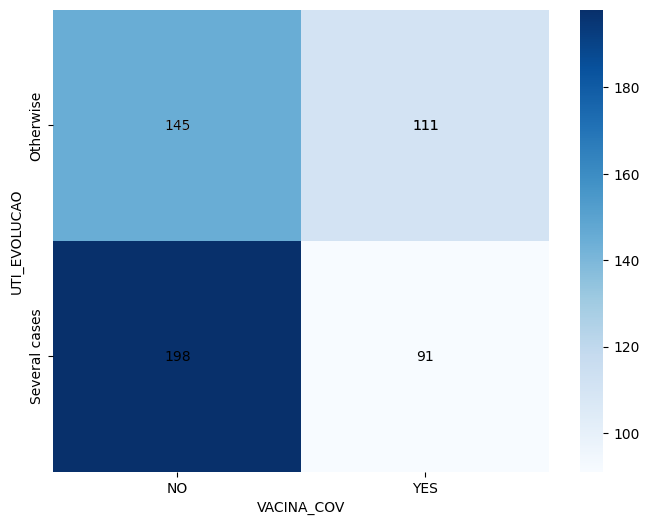

In [228]:
# Logistic regression model
print(f"Logistic regression model:")
model = smf.logit("UTI_EVOLUCAO ~ VACINA_COV" , data=df_temp).fit(disp=False)
print(model.summary())

# Odds ratios
odds_ratios = pd.DataFrame(
    {
        "OR": model.params,
        "Lower CI": model.conf_int()[0],
        "Upper CI": model.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios = odds_ratios.iloc[1:3]

# Plot odds ratios
print()
print(f"Odds ratios for VACINA_COV:")
print(odds_ratios)
print()

# Crosstab
crosstab = pd.crosstab(df_temp["VACINA_COV"], df_temp["UTI_EVOLUCAO"])

crosstab.rename(columns={1: "YES", 0: "NO"}, index={0: "Otherwise", 1: "Several cases"}, inplace=True)

plt.figure(figsize=(8, 6))
ax = sn.heatmap(crosstab, annot=True, fmt="d", cmap="Blues", cbar=True)

# Add values to each cell
for i in range(len(crosstab)):
    for j in range(len(crosstab.columns)):
        ax.text(j + 0.5, i + 0.5, crosstab.iloc[i, j],
                ha='center', va='center', color='black', fontsize=10)

plt.xlabel("VACINA_COV")
plt.ylabel("UTI_EVOLUCAO")
plt.show()

Analysis comparing vaccination coverage among cases of maternal death and ICU admission vs. patients who did not have either outcome for Omicrom

In [229]:
df_temp = df.loc[df['VARIANTE_COVID'] == 3].copy()  #Omicrom
df_temp.reset_index(inplace=True, drop=True)

#create a variable
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * np.nan

lista_obito = [1, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Individuals who were admitted to the ICU and died
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 1):  # Individuals admitted to the ICU who did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 0) and (df_temp['UTI'][i] == 0):  # Individuals who were not admitted to the ICU and did not die
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0
        
df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
df_temp = df_temp[df_temp['UTI_EVOLUCAO'] != 'Missing']
df_temp['UTI_EVOLUCAO'] = df_temp['UTI_EVOLUCAO'].astype(int)
df_temp = df_temp[df_temp['VACINA_COV'] != 'Missing']
df_temp['VACINA_COV'] = df_temp['VACINA_COV'].replace({"No": 0, "Yes": 1}) 
df_temp.reset_index(inplace=True, drop=True)

C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\1594960696.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
C:\Users\lucas\AppData\Local\Temp\ipykernel_14228\1594960696.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_temp['UTI_EVOLUCAO'].fillna('Missing', inplace=True)
C:\Users\

Logistic regression model:
                           Logit Regression Results                           
Dep. Variable:           UTI_EVOLUCAO   No. Observations:                 3174
Model:                          Logit   Df Residuals:                     3172
Method:                           MLE   Df Model:                            1
Date:                Sun, 19 May 2024   Pseudo R-squ.:               0.0002450
Time:                        11:30:06   Log-Likelihood:                -1241.9
converged:                       True   LL-Null:                       -1242.2
Covariance Type:            nonrobust   LLR p-value:                    0.4353
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8122      0.098    -18.482      0.000      -2.004      -1.620
VACINA_COV    -0.0909      0.116     -0.784      0.433      -0.318       0.136

Odds ratios for VACINA_C

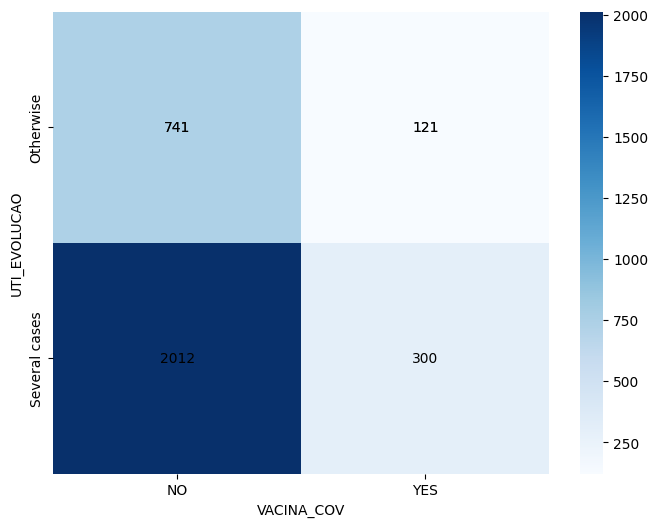

In [230]:
# Logistic regression model
print(f"Logistic regression model:")
model = smf.logit("UTI_EVOLUCAO ~ VACINA_COV" , data=df_temp).fit(disp=False)
print(model.summary())

# Odds ratios
odds_ratios = pd.DataFrame(
    {
        "OR": model.params,
        "Lower CI": model.conf_int()[0],
        "Upper CI": model.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios = odds_ratios.iloc[1:3]

# Plot odds ratios
print()
print(f"Odds ratios for VACINA_COV:")
print(odds_ratios)
print()

# Crosstab
crosstab = pd.crosstab(df_temp["VACINA_COV"], df_temp["UTI_EVOLUCAO"])

crosstab.rename(columns={1: "YES", 0: "NO"}, index={0: "Otherwise", 1: "Several cases"}, inplace=True)

plt.figure(figsize=(8, 6))
ax = sn.heatmap(crosstab, annot=True, fmt="d", cmap="Blues", cbar=True)

# Add values to each cell
for i in range(len(crosstab)):
    for j in range(len(crosstab.columns)):
        ax.text(j + 0.5, i + 0.5, crosstab.iloc[i, j],
                ha='center', va='center', color='black', fontsize=10)

plt.xlabel("VACINA_COV")
plt.ylabel("UTI_EVOLUCAO")
plt.show()

**Final considerations for the research**




*   There is no information to perform the logistic regression for intubation (I couldn't find the variable in the data dictionary)
*   No information on Neonatal severe outcomes was found in the data dictionary
*   No information in the data dictionary to build table 4
*   No information on Pregnancy outcomes was found in the data dictionary







